In [3]:
!pip install xgboost lightgbm catboost --quiet

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

plt.style.use("dark_background")
sns.set_palette("bright")

In [5]:
df_main = pd.read_csv("/content/weekly_features_engineered.csv")

df_main["Date"] = pd.to_datetime(df_main["Date"])
df_main = df_main.sort_values("Date")
df_main.replace([np.inf, -np.inf], np.nan, inplace=True)
df_main = df_main.dropna().reset_index(drop=True)

print("Dataset shape:", df_main.shape)

Dataset shape: (4727, 56)


In [6]:
TARGET = "Price"

X = df_main.drop(columns=["Date", "Vegetable", TARGET])
y = df_main[TARGET]

print("Feature shape:", X.shape)
print("Any inf left:", np.isinf(X).sum().sum())
print("Any NA left:", X.isna().sum().sum())

Feature shape: (4727, 53)
Any inf left: 0
Any NA left: 0


In [7]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    metrics = {}
    metrics["Train RMSE"] = np.sqrt(mean_squared_error(y_train, y_pred_train))
    metrics["Test RMSE"]  = np.sqrt(mean_squared_error(y_test,  y_pred_test))
    metrics["Test MAE"]   = mean_absolute_error(y_test, y_pred_test)
    metrics["Test R2"]    = r2_score(y_test, y_pred_test)
    metrics["Test MAPE"]  = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    return metrics

In [8]:
tscv = TimeSeriesSplit(n_splits=10)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (4298, 53)
Test size: (429, 53)


In [13]:
# XGBoost baseline params from training notebook
xgb_base_params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.01,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "alpha": 8,
    "lambda": 10,
    "seed": 42
}

# Tuning grid — testing around the baseline values
xgb_param_grid = {
    "max_depth":        [3, 4, 5],
    "subsample":        [0.7, 0.9],
    "colsample_bytree": [0.7, 0.9],
    "alpha":            [5, 10],
    "lambda":           [8, 12],
}

xgb_tuner = xgb.XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.01,
    n_estimators=2000,
    seed=42,
    early_stopping_rounds=50,
    eval_metric="rmse"
)

xgb_grid = GridSearchCV(
    xgb_tuner,
    xgb_param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

print("XGBoost Best params:", xgb_grid.best_params_)
print("XGBoost Best CV RMSE:", round(-xgb_grid.best_score_, 4))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
XGBoost Best params: {'alpha': 5, 'colsample_bytree': 0.9, 'lambda': 8, 'max_depth': 3, 'subsample': 0.7}
XGBoost Best CV RMSE: 22.4944


In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

best_xgb_params = {
    "objective":        "reg:squarederror",
    "learning_rate":    0.01,
    "seed":             42,
    **xgb_grid.best_params_
}

xgb_model_tuned = xgb.train(
    best_xgb_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=50,
    verbose_eval=False
)

y_pred_train = xgb_model_tuned.predict(dtrain)
y_pred_test  = xgb_model_tuned.predict(dtest)

xgb_metrics = {
    "Train RMSE": np.sqrt(mean_squared_error(y_train, y_pred_train)),
    "Test RMSE":  np.sqrt(mean_squared_error(y_test,  y_pred_test)),
    "Test MAE":   mean_absolute_error(y_test, y_pred_test),
    "Test R2":    r2_score(y_test, y_pred_test),
    "Test MAPE":  np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
}
print("XGBoost Tuned:", xgb_metrics)

XGBoost Tuned: {'Train RMSE': np.float64(7.600063853266238), 'Test RMSE': np.float64(20.21818295560692), 'Test MAE': 11.298826582570168, 'Test R2': 0.9862916792392429, 'Test MAPE': np.float64(2.5445038783319243)}


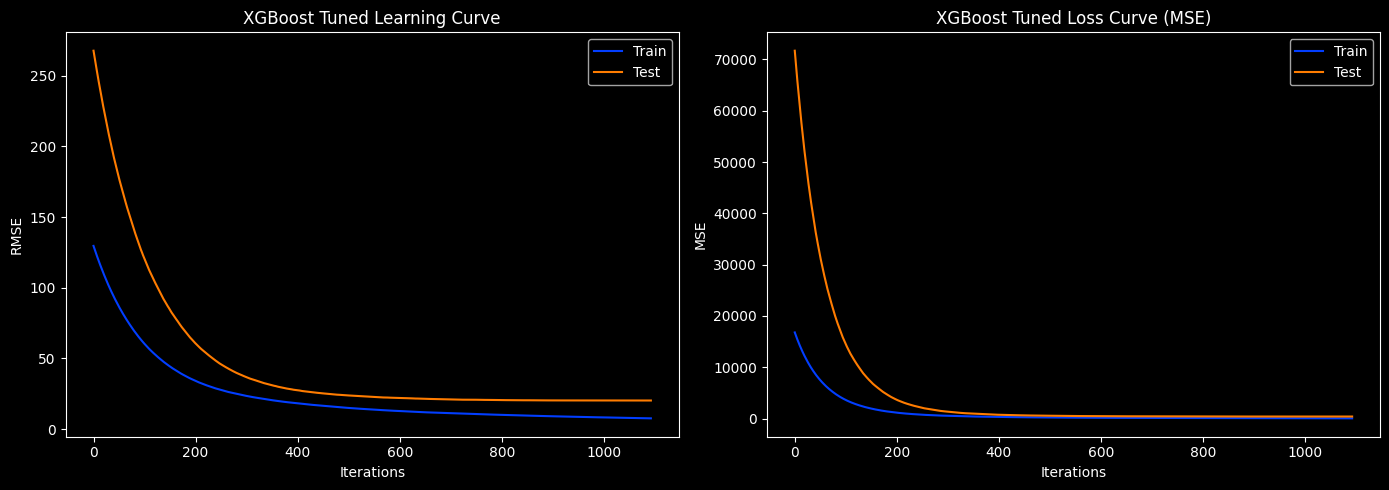

In [15]:
# XGBoost tuned learning curve + loss curve
evals_result = {}

xgb_model_tuned = xgb.train(
    best_xgb_params,
    dtrain,
    num_boost_round=2000,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=50,
    verbose_eval=False,
    evals_result=evals_result
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning curve (RMSE)
axes[0].plot(evals_result['train']['rmse'], label='Train')
axes[0].plot(evals_result['eval']['rmse'],  label='Test')
axes[0].set_title("XGBoost Tuned Learning Curve")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("RMSE")
axes[0].legend()

# Loss curve (MSE)
train_mse = [x**2 for x in evals_result['train']['rmse']]
test_mse  = [x**2 for x in evals_result['eval']['rmse']]
axes[1].plot(train_mse, label='Train')
axes[1].plot(test_mse,  label='Test')
axes[1].set_title("XGBoost Tuned Loss Curve (MSE)")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE")
axes[1].legend()

plt.tight_layout()
plt.show()

In [17]:
lgb_param_grid = {
    "n_estimators":      [1000, 2000],
    "learning_rate":     [0.005, 0.01],
    "max_depth":         [4, 6],
    "num_leaves":        [15, 20],
    "reg_alpha":         [1, 2],
    "reg_lambda":        [2, 3],
    "min_child_samples": [15, 20]
}

lgb_tuner = lgb.LGBMRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_grid = GridSearchCV(
    lgb_tuner,
    lgb_param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

lgb_grid.fit(X_train, y_train)

print("LightGBM Best params:", lgb_grid.best_params_)
print("LightGBM Best CV RMSE:", round(-lgb_grid.best_score_, 4))

Fitting 10 folds for each of 128 candidates, totalling 1280 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7564
[LightGBM] [Info] Number of data points in the train set: 4298, number of used features: 53
[LightGBM] [Info] Start training from score 187.750081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [18]:
lgb_model_tuned = lgb.LGBMRegressor(
    **lgb_grid.best_params_,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model_tuned.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric="rmse",
    callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]
)

lgb_metrics = evaluate_model(lgb_model_tuned, X_train, y_train, X_test, y_test)
print("LightGBM Tuned:", lgb_metrics)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7564
[LightGBM] [Info] Number of data points in the train set: 4298, number of used features: 53
[LightGBM] [Info] Start training from score 187.750081
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

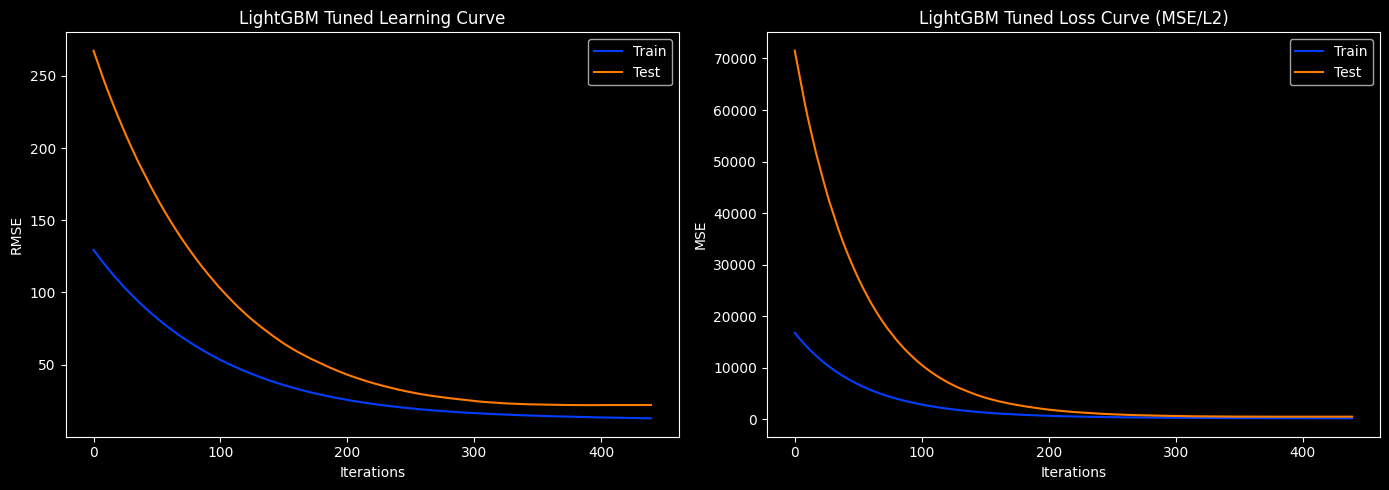

In [19]:
# LightGBM tuned learning curve + loss curve
evals_result = lgb_model_tuned.evals_result_

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning curve (RMSE)
axes[0].plot(evals_result['training']['rmse'], label='Train')
axes[0].plot(evals_result['valid_1']['rmse'],  label='Test')
axes[0].set_title("LightGBM Tuned Learning Curve")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("RMSE")
axes[0].legend()

# Loss curve (MSE = L2)
axes[1].plot(evals_result['training']['l2'], label='Train')
axes[1].plot(evals_result['valid_1']['l2'],  label='Test')
axes[1].set_title("LightGBM Tuned Loss Curve (MSE/L2)")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE")
axes[1].legend()

plt.tight_layout()
plt.show()

In [20]:
from catboost import CatBoostRegressor

cat_param_grid = {
    "depth":        [4, 5, 6],
    "l2_leaf_reg":  [8, 12, 16],
    "learning_rate":[0.01, 0.02, 0.05],
}

cat_tuner = CatBoostRegressor(
    iterations=2000,
    random_seed=42,
    od_type='Iter',
    od_wait=50,
    verbose=False
)

cat_grid = GridSearchCV(
    cat_tuner,
    cat_param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

cat_grid.fit(X_train, y_train)

print("CatBoost Best params:", cat_grid.best_params_)
print("CatBoost Best CV RMSE:", round(-cat_grid.best_score_, 4))

Fitting 10 folds for each of 27 candidates, totalling 270 fits
CatBoost Best params: {'depth': 4, 'l2_leaf_reg': 16, 'learning_rate': 0.05}
CatBoost Best CV RMSE: 20.3108


In [21]:
cat_model_tuned = CatBoostRegressor(
    **cat_grid.best_params_,
    iterations=2000,
    random_seed=42,
    od_type='Iter',
    od_wait=50,
    verbose=False
)

cat_model_tuned.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False
)

cat_metrics = evaluate_model(cat_model_tuned, X_train, y_train, X_test, y_test)
print("CatBoost Tuned:", cat_metrics)

CatBoost Tuned: {'Train RMSE': np.float64(2.5841437036388224), 'Test RMSE': np.float64(16.347920827038966), 'Test MAE': 9.394905028760588, 'Test R2': 0.9910375846853521, 'Test MAPE': np.float64(2.1047399646007197)}


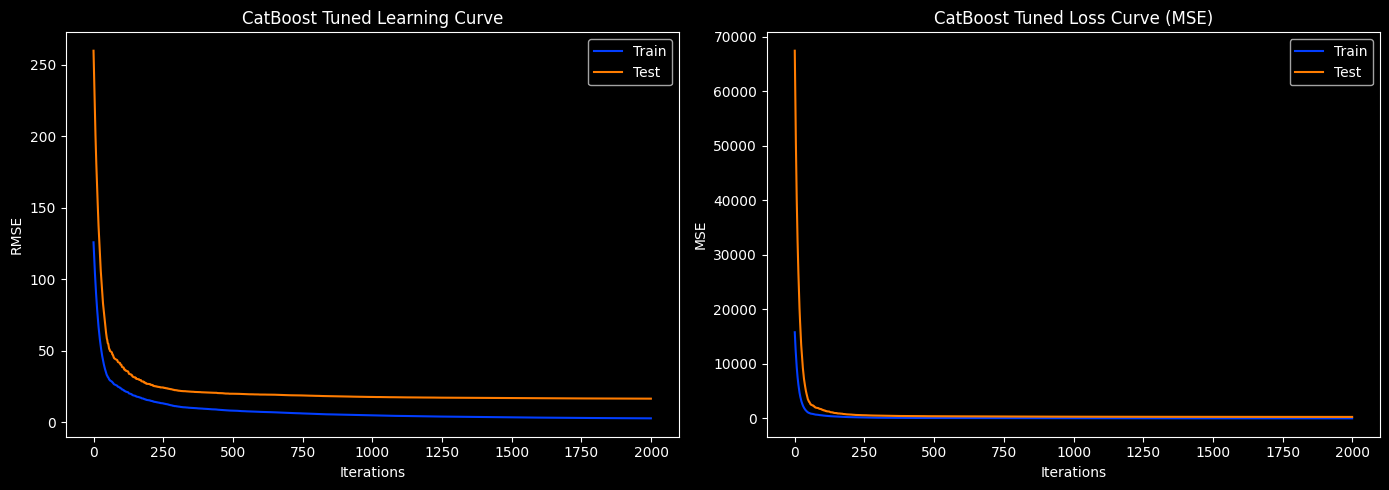

In [22]:
# CatBoost tuned learning curve + loss curve
results = cat_model_tuned.get_evals_result()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning curve (RMSE)
axes[0].plot(results['learn']['RMSE'],      label='Train')
axes[0].plot(results['validation']['RMSE'], label='Test')
axes[0].set_title("CatBoost Tuned Learning Curve")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("RMSE")
axes[0].legend()

# Loss curve (MSE)
train_mse = [x**2 for x in results['learn']['RMSE']]
test_mse  = [x**2 for x in results['validation']['RMSE']]
axes[1].plot(train_mse, label='Train')
axes[1].plot(test_mse,  label='Test')
axes[1].set_title("CatBoost Tuned Loss Curve (MSE)")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("MSE")
axes[1].legend()

plt.tight_layout()
plt.show()


In [23]:
comparison = pd.DataFrame([xgb_metrics, lgb_metrics, cat_metrics],
                          index=["XGBoost", "LightGBM", "CatBoost"])
comparison.sort_values("Test RMSE")

,Train RMSE,Test RMSE,Test MAE,Test R2,Test MAPE
CatBoost,2.584144,16.347921,9.394905,0.991038,2.104740
XGBoost,7.600064,20.218183,11.298827,0.986292,2.544504
LightGBM,13.675072,21.973093,11.368026,0.983809,2.349246


In [24]:
best_per_metric = comparison.idxmin()
best_per_metric['Test R2'] = comparison['Test R2'].idxmax()
print(best_per_metric)

ranks = comparison.rank(axis=0, ascending=[True, True, True, False])
avg_rank = ranks.mean(axis=1)
best_overall = avg_rank.idxmin()
print("Best overall model:", best_overall)

Train RMSE    CatBoost
Test RMSE     CatBoost
Test MAE      CatBoost
Test R2       CatBoost
Test MAPE     CatBoost
dtype: object
Best overall model: CatBoost


In [25]:
# Pick best tuned model based on comparison table
best_model_name = avg_rank.idxmin()
print("Best model:", best_model_name)

if best_model_name == "LightGBM":
    best_model = lgb_model_tuned
elif best_model_name == "CatBoost":
    best_model = cat_model_tuned
else:
    best_model = xgb_model_tuned

Best model: CatBoost


In [26]:
import pandas as pd
import numpy as np

# Get last known date in dataset
last_date = df_main["Date"].max()
print("Last date in dataset:", last_date)

# Generate future weekly dates (52 weeks = 1 year ahead)
future_dates = pd.date_range(start=last_date, periods=53, freq="W")[1:]

# Get unique vegetables
vegetables = df_main["Vegetable"].unique()
print("Vegetables:", vegetables)

# Use last known feature values per vegetable as base for prediction
future_rows = []

for veg in vegetables:
    veg_df = df_main[df_main["Vegetable"] == veg].sort_values("Date")
    last_row = veg_df.iloc[-1]  # most recent row

    for date in future_dates:
        row = last_row.copy()
        row["Date"] = date
        row["Vegetable"] = veg
        future_rows.append(row)

future_df = pd.DataFrame(future_rows).reset_index(drop=True)

# Prepare features same way as training
X_future = future_df.drop(columns=["Date", "Vegetable", "Price"])

# Predict
if best_model_name == "XGBoost":
    import xgboost as xgb
    dmatrix_future = xgb.DMatrix(X_future)
    future_preds = best_model.predict(dmatrix_future)
else:
    future_preds = best_model.predict(X_future)

# Build output dataframe
future_output = pd.DataFrame({
    "Date":       future_df["Date"].values,
    "Vegetable":  future_df["Vegetable"].values,
    "Predicted_Price": future_preds
})

future_output["Date"] = pd.to_datetime(future_output["Date"]).dt.strftime("%Y-%m-%d")
future_output = future_output.sort_values(["Vegetable", "Date"]).reset_index(drop=True)

print(future_output.head(20))

Last date in dataset: 2025-12-22 00:00:00
Vegetables: ['Tomatoes' 'Carrot' 'Cabbage' 'Pumpkin' 'Brinjals' 'Bitter Gourd']
          Date     Vegetable  Predicted_Price
0   2026-01-04  Bitter Gourd      1040.671936
1   2026-01-11  Bitter Gourd      1040.671936
2   2026-01-18  Bitter Gourd      1040.671936
3   2026-01-25  Bitter Gourd      1040.671936
4   2026-02-01  Bitter Gourd      1040.671936
5   2026-02-08  Bitter Gourd      1040.671936
6   2026-02-15  Bitter Gourd      1040.671936
7   2026-02-22  Bitter Gourd      1040.671936
8   2026-03-01  Bitter Gourd      1040.671936
9   2026-03-08  Bitter Gourd      1040.671936
10  2026-03-15  Bitter Gourd      1040.671936
11  2026-03-22  Bitter Gourd      1040.671936
12  2026-03-29  Bitter Gourd      1040.671936
13  2026-04-05  Bitter Gourd      1040.671936
14  2026-04-12  Bitter Gourd      1040.671936
15  2026-04-19  Bitter Gourd      1040.671936
16  2026-04-26  Bitter Gourd      1040.671936
17  2026-05-03  Bitter Gourd      1040.671936
18  

In [29]:
future_output.to_csv("/content/future_price_predictions.csv", index=False)
print("Saved to /content/future_price_predictions.csv")
print("Total predictions:", len(future_output))
print("Weeks ahead:", 52)
print("Vegetables covered:", future_output["Vegetable"].nunique())

Saved to /content/future_price_predictions.csv
Total predictions: 312
Weeks ahead: 52
Vegetables covered: 6


In [31]:
import joblib
import os

# Create folder to save tuned models
os.makedirs("/content/tuned_models", exist_ok=True)

# Save tuned LightGBM
joblib.dump(lgb_model_tuned, "/content/tuned_models/lgb_tuned.pkl")

# Save tuned CatBoost
joblib.dump(cat_model_tuned, "/content/tuned_models/cat_tuned.pkl")

# Save tuned XGBoost (native booster uses its own save method)
xgb_model_tuned.save_model("/content/tuned_models/xgb_tuned.json")

print("All tuned models saved:")
print("  /content/tuned_models/lgb_tuned.pkl")
print("  /content/tuned_models/cat_tuned.pkl")
print("  /content/tuned_models/xgb_tuned.json")

All tuned models saved:
  /content/tuned_models/lgb_tuned.pkl
  /content/tuned_models/cat_tuned.pkl
  /content/tuned_models/xgb_tuned.json
